In [3]:
import numpy as np
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
import math
import random as r
import scipy.stats
import os.path
import sys
sys.path.append('/home/machado.35/projects/notebooks')
from deprojectGalaxy import deproject
import time

In [9]:
# This block of code contains the supporting functions to generate 
# a random distribution, you should not need to call any of these 
# funcitons specifically.

def arraySort(variable, distance):
    # sorts variable and distance list by shortest distance
    # variable, distance: lists holding measurement of variable and distance to that measurement
    pattern = distance.argsort()
    dist = distance[pattern]
    var = variable[pattern]
    return (var, dist)

def findNearest(varArray, value, distArray):
    # sorts variable by distance, returning the closest that has the given value 
    # varArray, distArray: arrays holding measurement of variable and distance to that measurement
    # value: float. 
    var, dist = arraySort(varArray, distArray)
    ind = np.where(var >= value)
    
    if len(dist[ind]) > 0:
        nearestVal  = np.argmin(dist[ind])
        nearestDist = dist[ind][nearestVal] 
        varVal     = var[ind][nearestVal]

    else:
        varVal     = float('nan')
        nearestDist = float('nan')
        
    return(varVal, nearestDist)
    
def printNearest(inten, SNR, dist_kpc, value, SNRcutoff = 0.0):
    # returns distance to the nearest molecular cloud and the intensity value found
    
    #apply SNR cutoff
    intenCut, dist_kpcCut = [],[]
    for i in range(len(inten)):
        if (SNR[i] >= SNRcutoff):
            intenCut.append(inten[i])
            dist_kpcCut.append(dist_kpc[i])
    
    valFound, nearestMC = findNearest(np.array(intenCut), value, np.array(dist_kpcCut))
    
    return(nearestMC, valFound)      

def distanceCalculator(x1, x2, y1, y2, galDist):
    #calculate distance between two points (in kpc)
    #x1, y1 = xprime and yprime, x2, y2 = SN coords, dist = distance to galaxy (kpc)
    d = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    x = galDist * np.tan(d*np.pi/180.0)
    return(x)

def normalize(weightsArray):
    # takes a list of weights and normalizes them
    prob_factor = 1 / sum(weightsArray)
    return [prob_factor * p for p in weightsArray]


In [10]:
def place_nclouds_in_map(image, n_clouds, outfile_name, galRA, galDEC, pa, incl, galDist):
    
    hdulist   = pyfits.open(image)
    intMap    = hdulist[0].data
        
    wcs      = WCS(hdulist[0].header, naxis=2)
    naxis    = wcs._naxis # size of image naxis[0] = x and [1] = y
    grid     = np.indices((naxis[1],naxis[0]))
    ra, dec  = wcs.wcs_pix2world(grid[1],grid[0],0)

    centerCoord = [galRA, galDEC]
    
    #deproject ra and dec to dx and dy
    radius, projang, dx, dy = deproject(center_coord=centerCoord, incl=incl, pa=pa, ra=ra, dec=dec, return_offset=True)
    

    #flatten data structures 
    f_int  = intMap.flatten()
    f_ra   = ra.flatten()
    f_dec  = dec.flatten()    
    f_dx   = dx.flatten()
    f_dy   = dy.flatten()       
    
    #remove nans
    keep  = np.where(np.isfinite(f_int))
    inten = f_int[keep]
    ra    = f_ra[keep]
    dec   = f_dec[keep]
    dx    = f_dx[keep]
    dy    = f_dy[keep]
    
    if np.any(inten < 0):
        inten[np.where(inten < 0)] = 0
    
    #Convert image into probabilities
    total = sum(inten)
    prob  = inten/total
    
    #Generates index for each coordinate pair
    nX = len(dx)  
    indicies = np.arange(nX, dtype=int)
    
    
    #Probability weighted random placement
    randInt = np.random.choice(indicies, p=prob, size=int(n_clouds))

    rX   = dx[randInt]
    rY   = dy[randInt]
    rRA  = ra[randInt]
    rDEC = dec[randInt]
    
    df = pd.DataFrame()
    df['rX'] = rX
    df['rY'] = rY
    df['rRA'] = rRA
    df['rDEC'] = rDEC
    df.to_csv(outfile_name)

    return()

In [13]:
sources = pd.read_csv('/home/machado.35/projects/intro/scripts/sources.csv')
sources = list(sources['sources'])

res = [60,90,120,150]

In [ ]:
#2D COVERAGE
n_clouds = 1e6
for k in range(len(res)):
    for i in range(len(sources)):
        image = mask_fp+sources[i]+'_12m+7m+tp_co21_'+str(res[k])+'pc_coverage2d.fits'
        if os.path.isfile(image):
            row = int(np.where(t['name'] == sources[i])[0])
            galRA=t[row]['orient_ra']
            galDEC=t[row]['orient_dec']
            pa=t[row]['orient_posang']
            incl=t[row]['orient_incl']
            galDist=t[row]['dist']
            outfile_name = '/data/rubin/machado.35/phangs/rand_results/1e6/'+sources[i]+'_2dcov'+'_'+str(res[k])+'pc.csv'
            place_nclouds_in_map(image, n_clouds, outfile_name, galRA, galDEC, pa, incl, galDist)

In [ ]:
#EXP MASK
tab_loc = '/home/machado.35/projects/intro/phangs_sample_table_v1p6.fits'
t = Table.read(tab_loc)
n_clouds = 1e6
for k in range(len(res)):
    for i in range(len(sources)):
        image = '/home/machado.35/projects/masks/exp/'+sources[i]+'_'+str(res[k])+'pc_exp_mask.fits'
        if os.path.isfile(image):
            row = int(np.where(t['name'] == sources[i])[0])
            galRA=t[row]['orient_ra']
            galDEC=t[row]['orient_dec']
            pa=t[row]['orient_posang']
            incl=t[row]['orient_incl']
            galDist=t[row]['dist']
            outfile_name = '/data/rubin/machado.35/phangs/rand_results/1e6/'+sources[i]+'_exp'+'_'+str(res[k])+'pc.csv'
            place_nclouds_in_map(image, n_clouds, outfile_name, galRA, galDEC, pa, incl, galDist)

In [12]:
def pair_dist_calc(x,y):
    n = len(x)
    x1 = np.tile(x, (n,1)) #constant x along column
    y1 = np.tile(y, (n,1)) #constant y along column
    x2 = np.transpose(x1) #constant x along rows
    y2 = np.transpose(y1) #constant y along rows
    dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    
    np.ndarray.sort(dist, axis=1)
    mindist = dist[:,1]

    return(mindist)

In [37]:
def rad_density(x,y,rad,galdist):
    n = len(x)
    x1 = np.tile(x, (n,1)) #constant x along column
    y1 = np.tile(y, (n,1)) #constant y along column
    x2 = np.transpose(x1) #constant x along rows
    y2 = np.transpose(y1) #constant y along rows
    dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    dist = np.deg2rad(dist)*galdist
    inrad = dist < rad 
    counts = np.sum(inrad, axis=0) - 1 #subtract one because each cloud has 0 distance to itself and will be counted
    return(counts)

In [68]:
tab_loc = '/home/machado.35/projects/intro/phangs_sample_table_v1p6.fits'
t = Table.read(tab_loc)
distance = t[t['name'] == 'ngc3621']['dist'][0] * 1e6

In [90]:
x = df['rRA']
y = df['rDEC']
N_tot = len(x)
n_it = len(cat)
n_loops = int(np.floor(N_tot / n_it))
clouds_in_range = np.zeros_like(x)*np.nan
z = np.zeros_like(x)*np.nan
for ii in np.arange(n_loops):
    tx = x[ii*n_it:(ii+1)*n_it]
    ty = y[ii*n_it:(ii+1)*n_it]
    z[ii*n_it:(ii+1)*n_it] = rad_density(x=tx,y=ty, rad=400, galdist=distance)


(array([5.46722e+05, 1.72183e+05, 1.89362e+05, 4.40300e+04, 3.72650e+04,
        6.04500e+03, 3.64800e+03, 4.44000e+02, 2.09000e+02, 1.20000e+01]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <BarContainer object of 10 artists>)

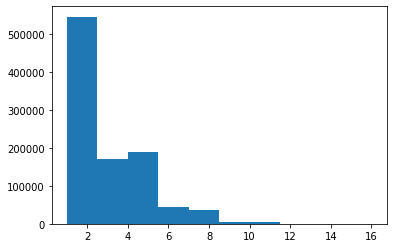

In [96]:
plt.hist(z)

In [23]:
ii=0
tx = x[ii*n_it:(ii+1)*n_it]
ty = y[ii*n_it:(ii+1)*n_it]
clouds_in_range[ii*n_it:(ii+1)*n_it] = rad_density(x=tx,y=ty, rad=400)
print(clouds_in_range)

ValueError: could not broadcast input array from shape (145,145) into shape (145)

In [9]:
#EXP DISK
source = sources[32]
tab_loc = '/home/machado.35/projects/intro/phangs_sample_table_v1p6.fits'
t = Table.read(tab_loc)
for k in range(len(res)):
    k=3
    for i in range(len(source)):
        i=32
        image = '/home/machado.35/projects/masks/exp/'+sources[i]+'_'+str(res[k])+'pc_exp_mask.fits'
        cat_fp = '/home/machado.35/projects/intro/sources/'+sources[i]+'/'+sources[i]+'_'+str(res[k])+'pc_cloud_stats.csv'
        if os.path.isfile(image):
            if os.path.isfile(cat_fp):
                row = int(np.where(t['name'] == sources[i])[0])
                dist = t['dist'][row]*1e6 #from Mpc to pc
                fn = '/data/rubin/machado.35/phangs/rand_results/1e6/'+sources[i]+'_exp'+'_'+str(res[k])+'pc.csv'
                df = pd.read_csv(fn)
                cat = pd.read_csv(cat_fp)
                x = df['rRA']
                y = df['rDEC']
                N_tot = len(x)
                n_it = len(cat)
                n_loops = int(np.floor(N_tot / n_it))
                clouds_in_range = np.zeros_like(x)*np.nan
                for ii in np.arange(n_loops):
                    tx = x[ii*n_it:(ii+1)*n_it]
                    ty = y[ii*n_it:(ii+1)*n_it]
                    clouds_in_range[ii*n_it:(ii+1)*n_it] = rad_density(x=tx,y=ty, rad=400)
                print(clouds_in_range)

[21025. 21025. 21025. ...    nan    nan    nan]
[21025. 21025. 21025. ...    nan    nan    nan]
[21025. 21025. 21025. ...    nan    nan    nan]
[21025. 21025. 21025. ...    nan    nan    nan]
[21025. 21025. 21025. ...    nan    nan    nan]
[21025. 21025. 21025. ...    nan    nan    nan]
[21025. 21025. 21025. ...    nan    nan    nan]


KeyboardInterrupt: 

In [15]:
np.nanmax(clouds_in_range)

21025.0

In [27]:
dist

7059999.942779541

In [ ]:
tab_loc = '/home/machado.35/projects/intro/phangs_sample_table_v1p6.fits'
t = Table.read(tab_loc)
row = int(np.where(t['name'] == 'ngc3621')[0])
t['dist'][row]

In [ ]:
ra1 = df['rRA'][15]
dec1 = df['rDEC'][15]
ra2 = df['rRA'][16]
dec2 = df['rDEC'][16]
np.sqrt(np.square(ra1 - ra2) + np.square(dec1 - dec2))*t['dist'][row]*1e3

In [ ]:
#2D COVERAGE
tab_loc = '/home/machado.35/projects/intro/phangs_sample_table_v1p6.fits'
t = Table.read(tab_loc)
for k in range(len(res)):
    for i in range(len(sources)):
        image = mask_fp+sources[i]+'_12m+7m+tp_co21_'+str(res[k])+'pc_coverage2d.fits'
        cat_fp = '/home/machado.35/projects/intro/sources/'+sources[i]+'/'+sources[i]+'_'+str(res[k])+'pc_cloud_stats.csv'
        if os.path.isfile(image):
            if os.path.isfile(cat_fp):
                row = int(np.where(t['name'] == sources[i])[0])
                dist = t['dist'][row]*1e6 #from Mpc to pc
                fn = '/data/rubin/machado.35/phangs/rand_results/1e6/'+sources[i]+'_2dcov'+'_'+str(res[k])+'pc.csv'
                df = pd.read_csv(fn)
                cat = pd.read_csv(cat_fp)
                x = df['rRA']
                y = df['rDEC']
                N_tot = len(x)
                n_it = len(cat)
                n_loops = int(np.floor(N_tot / n_it))
                mindist = np.zeros_like(x)*np.nan
                for ii in np.arange(n_loops):
                    tx = x[ii*n_it:(ii+1)*n_it]
                    ty = y[ii*n_it:(ii+1)*n_it]
                    mindist[ii*n_it:(ii+1)*n_it] = pair_dist_calc(x=tx,y=ty)
                df['nn_dist'] = np.deg2rad(mindist) * dist
                df.to_csv(fn)

In [ ]:
#EXP DISK
radius = 400 #COUNTING CLOUDS WITHIN RADIUS
tab_loc = '/home/machado.35/projects/intro/phangs_sample_table_v1p6.fits'
t = Table.read(tab_loc)
for k in range(len(res)):
    for i in range(len(sources)):
        image = '/home/machado.35/projects/masks/exp/'+sources[i]+'_'+str(res[k])+'pc_exp_mask.fits'
        cat_fp = '/home/machado.35/projects/intro/sources/'+sources[i]+'/'+sources[i]+'_'+str(res[k])+'pc_cloud_stats.csv'
        fn = '/data/rubin/machado.35/phangs/rand_results/1e6/'+sources[i]+'_exp'+'_'+str(res[k])+'pc.csv'
        if os.path.isfile(image):
            if os.path.isfile(cat_fp):
                if os.path.isfile(fn):
                    row = int(np.where(t['name'] == sources[i])[0])
                    dist = t['dist'][row]*1e6 #from Mpc to pc
                    df = pd.read_csv(fn)
                    cat = pd.read_csv(cat_fp)
                    x = df['rRA']
                    y = df['rDEC']
                    N_tot = len(x)
                    n_it = len(cat)
                    n_loops = int(np.floor(N_tot / n_it))
                    mindist = np.zeros_like(x)*np.nan
                    radial_density = np.zeros_like(x)*np.nan
                    for ii in np.arange(n_loops):
                        tx = x[ii*n_it:(ii+1)*n_it]
                        ty = y[ii*n_it:(ii+1)*n_it]
                        mindist[ii*n_it:(ii+1)*n_it] = pair_dist_calc(x=tx,y=ty)
                        radial_density[ii*n_it:(ii+1)*n_it] = rad_density(x=tx,y=ty, rad=radius, galdist=dist)
                    df['nn_dist'] = np.deg2rad(mindist) * dist
                    df['clouds_r'+str(radius)+'pc'] = radial_density
                    df.to_csv(fn)

In [ ]:
df = pd.read_csv('ngc3621_exp_testrun.csv')
x = df['rX']
y = df['rY']
N_tot = len(x)
n_it = 150
n_loops = int(np.floor(N_tot / n_it))
counter = 0
print(str(N_tot)+' total points, with '+str(n_it)+' iterations. '+str(n_loops)+' to complete')
mindist = np.zeros_like(x)*np.nan
for ii in np.arange(n_loops):
    tx = x[ii*n_it:(ii+1)*n_it]
    ty = y[ii*n_it:(ii+1)*n_it]
    mindist[ii*n_it:(ii+1)*n_it] = pair_dist_calc(x=tx,y=ty)

In [108]:
sources[32]

'ngc3621'

In [114]:
#EXP DISK
radius = 400 #COUNTING CLOUDS WITHIN RADIUS
tab_loc = '/home/machado.35/projects/intro/phangs_sample_table_v1p6.fits'
t = Table.read(tab_loc)
source = sources[32] #####
for k in range(len(res)): 
    k=3 #####
    for i in range(len(source)): ####
        image = '/home/machado.35/projects/masks/exp/'+sources[i]+'_'+str(res[k])+'pc_exp_mask.fits'
        cat_fp = '/home/machado.35/projects/intro/sources/'+sources[i]+'/'+sources[i]+'_'+str(res[k])+'pc_cloud_stats.csv'
        fn = '/data/rubin/machado.35/phangs/rand_results/1e6/'+sources[i]+'_exp'+'_'+str(res[k])+'pc.csv'
        if os.path.isfile(image):
            if os.path.isfile(cat_fp):
                if os.path.isfile(fn):
                    row = int(np.where(t['name'] == sources[i])[0])
                    dist = t['dist'][row]*1e6 #from Mpc to pc
                    df = pd.read_csv(fn)
                    cat = pd.read_csv(cat_fp)
                    x = df['rRA']
                    y = df['rDEC']
                    N_tot = len(x)
                    n_it = len(cat)
                    n_loops = int(np.floor(N_tot / n_it))
                    mindist = np.zeros_like(x)*np.nan
                    radial_density = np.zeros_like(x)*np.nan
                    for ii in np.arange(n_loops):
                        tx = x[ii*n_it:(ii+1)*n_it]
                        ty = y[ii*n_it:(ii+1)*n_it]
                        mindist[ii*n_it:(ii+1)*n_it] = pair_dist_calc(x=tx,y=ty)
                        radial_density[ii*n_it:(ii+1)*n_it] = rad_density(x=tx,y=ty, rad=radius, galdist=dist)
                    df['nn_dist'] = np.deg2rad(mindist) * dist
                    df['clouds_r'+str(radius)+'pc'] = radial_density
                    df.to_csv(fn)

In [116]:
df['clouds_r400pc']

0         2.0
1         2.0
2         3.0
3         1.0
4         3.0
         ... 
762416    NaN
762417    NaN
762418    NaN
762419    NaN
762420    NaN
Name: clouds_r400pc, Length: 762421, dtype: float64

In [117]:
len(x)

762421

In [29]:
k = 3
i = 32
#REAL DATA TRIAL RUN
radius = 400 #pc
tab_loc = '/home/machado.35/projects/intro/phangs_sample_table_v1p6.fits'
t = Table.read(tab_loc)
real_cat = '/home/machado.35/projects/intro/sources/'+sources[i]+'/'+sources[i]+'_'+str(res[k])+'pc_cloud_stats.csv'
cat = pd.read_csv(real_cat)
row = int(np.where(t['name'] == sources[i])[0])
dist = t['dist'][row]*1e6 #from Mpc to pc
x = cat['corr_x']
y = cat['y']
neighbor_counts = rad_density(x=x, y=y, rad=radius, galdist=dist)
copy_cat = cat
copy_cat['clouds_r'+str(radius)+'pc'] = neighbor_counts
#df.to_csv(fn)

In [38]:
#REAL DATA FULL RUN
radius = 400 #pc
tab_loc = '/home/machado.35/projects/intro/phangs_sample_table_v1p6.fits'
t = Table.read(tab_loc)
for k in range(len(res)):
    for i in range(len(sources)):
        real_cat = '/home/machado.35/projects/intro/sources/'+sources[i]+'/'+sources[i]+'_'+str(res[k])+'pc_cloud_stats.csv'
        if os.path.isfile(real_cat):
            cat = pd.read_csv(real_cat)
            row = int(np.where(t['name'] == sources[i])[0])
            dist = t['dist'][row]*1e6 #from Mpc to pc
            x = cat['corr_x']
            y = cat['y']
            neighbor_counts = rad_density(x=x, y=y, rad=radius, galdist=dist)
            cat['clouds_r'+str(radius)+'pc'] = neighbor_counts
            cat.to_csv(real_cat)

In [10]:
tab_loc = '/home/machado.35/projects/intro/phangs_sample_table_v1p6.fits'
t = Table.read(tab_loc)
t['name'][33]

'ngc1672'

In [20]:
row = int(np.where(t['name'] == sources[i])[0])
dist = t['dist'][row]*1e6 #from Mpc to pc

In [ ]:
mask_fp

In [14]:
k = 3
i = 1

In [15]:
real_cat = '/home/machado.35/projects/intro/sources/'+sources[i]+'/'+sources[i]+'_'+str(res[k])+'pc_cloud_stats.csv'

In [21]:
cat = pd.read_csv(real_cat)
x = cat['corr_x']
y = cat['y']
galdist = dist